In [ ]:
!pip install pymatgen
from multiprocessing import Pool
import os
import re
from IPython.core.pylabtools import figsize
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from math import pi,sin,cos,sqrt,exp, ceil, factorial
import scipy
import h5py
import pymatgen as mg
from numba import njit
import random
from pymatgen.core import Structure
from pymatgen.analysis.ewald import EwaldSummation
import time
import statistics as stat
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

**CIF Processing**

In [ ]:
def extract_num(string):
  result = re.findall(r"[-+]?\d*\.\d+|\d+", string)
  floats = []
  for i in range(len(result)):
    floats.append(float(result[i]))
  return floats

def cif_processing(struct):
  t1 = time.time()
  H = EwaldSummation(struct).total_energy_matrix
  Li_sites = []
  non_Li_sites = []
  for i in range(len(struct)):
    if ''.join(filter(str.isalpha, struct.sites[i].species_string)) == 'Li':
      Li_sites.append(i)
    else:
      non_Li_sites.append(i)
  Li_occu = []
  for i in range(len(struct)):
    if ''.join(filter(str.isalpha, struct.sites[i].species_string)) == 'Li':
      # Li_occu.append(float(''.join(filter(str.isdigit, struct.sites[i].species_string)))/10**(len(''.join(filter(str.isdigit, struct.sites[i].species_string)))-1))
      try:
        Li_occu.append(extract_num(struct.sites[i].species_string)[0])
      except:
        Li_occu.append(1)
  t2 = time.time()
  print (t2 -t1)
  return H, np.array(Li_sites), np.array(non_Li_sites), np.array(Li_occu)

@njit
def A_matrix(H, Li_sites, non_Li_sites, Li_occu):
  A_ew = np.zeros((len(Li_sites),len(Li_sites)))
  V = np.zeros(len(Li_sites))
  for i in range(len(Li_sites)):
    for j in range(len(non_Li_sites)):
      A_ew[i,i] = A_ew[i,i] + H[Li_sites[i],non_Li_sites[j]]/Li_occu[i]
      V[i] = A_ew[i,i]
  for i in range(len(Li_sites)):
    A_ew[i,i] = A_ew[i,i] + H[Li_sites[i],Li_sites[i]] / Li_occu[i]**2
    V[i] = A_ew[i,i]
  for i in range(len(Li_sites)):
    for j in range(len(Li_sites)):
      if i != j:
        A_ew[i,j] = 0.5*(H[Li_sites[i],Li_sites[j]] / (Li_occu[i]*Li_occu[j]))
      elif i == j:
        continue
  return (0.6/(np.max(V)-np.min(V)))*A_ew

@njit
def Energy(state,matrix):
  return np.dot(state,np.dot(matrix,state))

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def make_graph(struct, cutoff_dist):
  Li_Sites = []
  Li_indices = []
  for i in range(len(struct)):
    if ''.join(filter(str.isalpha, struct[i].species_string)) == 'Li':
      Li_Sites.append(struct[i])
      Li_indices.append(i)
  Nbr_list = struct.get_neighbor_list(cutoff_dist, sites=Li_Sites)
  graf = []
  for n in range(len(Nbr_list[0])):
    if (Nbr_list[1][n] in Nbr_list[0]) and Nbr_list[0][n] < Nbr_list[1][n]:
      graf.append([Nbr_list[0][n], Nbr_list[1][n]])
  return np.array(graf)

def generate_state(n_sites,density):
  N_Li = int(density*n_sites)
  state = np.zeros(n_sites, dtype=bool)
  inds = np.random.choice(np.arange(len(state)), size=n_sites, replace=False)
  state[inds] = True
  return state

**MC Function**

In [ ]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
  x = np.atleast_1d(x)
  if len(x.shape) != 1:
    raise ValueError("invalid dimensions for 1D autocorrelation function")
  n = next_pow_two(len(x))
  # Compute the FFT and then (from that) the auto-correlation function
  f = np.fft.fft(x - np.mean(x), n=2 * n)
  acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
  acf /= 4 * n
  # Optionally normalize
  if norm:
    acf /= acf[0]
  return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [ ]:
@njit
def switch(state,i,j):
  nw_state = state.copy()
  nw_state[i], nw_state[j] = state[j], state[i]
  return nw_state


@njit
def switch_energy(state,i,j, A):
  n_i, n_j = state[i], state[j]
  nw_state = switch(state,i,j)
  if n_i==1 and n_j==0:
    return np.dot(nw_state,A[:,j]) +np.dot(state,A[:,j]) - np.dot(state,A[:,i]) - np.dot(nw_state,A[:,i])
  elif n_i==0 and n_j==1:
    return np.dot(nw_state,A[:,i]) +np.dot(state,A[:,i]) - np.dot(state,A[:,j]) - np.dot(nw_state,A[:,j])
  else:
    return 0.0

@njit
def switch_energy1(state,i,j, A):
  n_i, n_j = state[i], state[j]
  nw_state = switch(state,i,j)
  if n_i==1 and n_j==0:
    return 2*(np.dot(nw_state,A[:,j]) - np.dot(state,A[:,i])) - A[j,j] + A[i,i]
  elif n_i==0 and n_j==1:
    return 2*(np.dot(nw_state,A[:,i]) - np.dot(state,A[:,j])) - A[i,i] + A[j,j]
  else:
    return 0.0

def switch_energy_fields(state,fields,vac,fil,A_mat):
  return 2*(fields[fil]-fields[vac]-A_mat[vac,fil]) + A_mat[fil,fil] + A_mat[vac,vac]

def update_rule(bond_vals,inds,rule=1):
  """
  Parameters:

  - bond_vals: array of bond values (1,0,-1). Same indices as Nbr_graph
  - inds: Nbr_graph indices at which 1st and 2nd neighbor's bonds are located
  - rule: turn the bond values 0 at inds into +1 or -1

  """
  for i in inds:
    if bond_vals[i] != 0:
      bond_vals[i] = 0
    elif rule==2:
      bond_vals[i] = -1
    elif rule==1:
      bond_vals[i] = 1
  return bond_vals

def MHMC(nsteps, state, beta, density, graph, A_mat):
    flattened = graph.ravel()
    Li_sites = np.unique(flattened)
    n_sites = len(Li_sites)
    k_B = 8.617333262*10**(-5)
    s = 0
    n_itt = 0
    E_i = Energy(state, A_mat)
    eff_fields = np.dot(A_mat, state)
    energies = [E_i]
    # states = [state]
    for step in range(nsteps):
      bond_fillings = state[graph]
      bond_inds = np.where((bond_fillings[:,0] != bond_fillings[:,1]))[0]
      p = np.random.choice(bond_inds)
      i1,i2 = graph[p]
      mini_state = state[np.array([i1,i2])]
      fil,vac = np.array([i1,i2])[np.argsort(mini_state)]
      prop_state = switch(state, i1, i2)
      dE = switch_energy_fields(state, eff_fields, vac=vac, fil=fil, A=A_mat)
      if dE < 0 or np.exp(-(dE)*beta) > np.random.rand():
        # states.append(prop_state)
        energies.append(E_i + dE)
        state = prop_state
        E_i = energies[-1]
        eff_fields = eff_fields + A[:,fil] - A[:,vac]
        s += 1
      else:
        energies.append(E_i)
        continue
    accpt = s / nsteps
    #print('acc. rate = '+str(s/n_itt))
    return state, energies

In [ ]:
def T_to_beta(T_min,T_max,num_replicas):
  Ts = np.linspace(T_min,T_max,num_replicas)
  betas = 1 / (8.617333262*10**(-5)*Ts)
  return betas

def attempt_swaps(states, betas, A_mat):
  num_replicas = len(betas)
  new_states = states.copy()
  for i in range(num_replicas - 1):
    beta_diff = betas[i+1] - betas[i]
    energy_diff = Energy(new_states[i + 1], A_mat) - Energy(new_states[i], A_mat)
    delta = beta_diff * energy_diff
    if delta < 0 or np.random.rand() < np.exp(-delta):
      new_states[i], new_states[i + 1] = new_states[i + 1], new_states[i]
  return new_states

def parallel_tempering_mc(nsteps, nswap, states, betas, density, graph, A_mat, n_processes, save_period=10000, filename='mhmc.hdf5'):
  num_replicas = len(betas)
  interval = nsteps // nswap
  energy_history_all = [[] for i in range(num_replicas)]
  for step in range(interval):
    with Pool(processes=n_processes) as pool:
      args = [(nswap,states[i],betas[i],density,graph,A_mat) for i in range(num_replicas)]
      results = pool.starmap(MHMC,args)
      states, energy_histories = zip(*results)
      for rep in range(num_replicas):
        energy_history_all[rep].append(energy_histories[rep])
      #energy_history_all[:, i*nswap:(i+1)*nswap] = energy_histories
    states = attempt_swaps(states, betas, A_mat)
    if step % save_period==0 and step>0:
      with h5py.File(filename, 'a') as f:
        f.create_dataset(f'energies/interval_{step}', data=np.array(energy_history_all))
      for energies in energy_history_all:
        energies.clear()

In [ ]:
def rates(state, graph, bond_vals, fields, A, T, kB = 8.617333262*10**(-5), r0=1):
  nz_bond_inds = np.nonzero(bond_vals)[0]
  fst_inds, scnd_inds = graph[:,0][nz_bond_inds], graph[:,1][nz_bond_inds]
  open_bond_energies = bond_vals[nz_bond_inds]*(2*(fields[fst_inds]-fields[scnd_inds]-\
                       A[np.array(list(zip(fst_inds,scnd_inds)))]) + A[np.array(list(zip(fst_inds,fst_inds)))] + A[np.array(list(zip(scnd_inds,scnd_inds)))])
  rates = np.zeros(len(bond_vals))
  energy_diffs = rates.copy()
  rates[nz_bond_inds] = r0*np.exp(-open_bond_energies/(kB*T))
  cum_rates = rates.cumsum()
  energy_diffs[nz_bond_inds] = open_bond_energies
  return rates, cum_rates, energy_diffs

def choose_next_state(state, graph, cum_rates, bond_vals):
    i=0
    Q = cum_rates[-1]
    u = np.random.random()
    while cum_rates[i] < u*Q:
        i += 1
    site1, site2 = graph[i]
    new_state = switch(state,site1,site2)
    return new_state, i

def KMC(nsteps, state, T, density, graph, A_mat, kB = 8.617333262*10**(-5), r0=1, save_interval=20000, filename = 'kmc_simulation0.hdf5'):
    flattened = graph.ravel()
    Li_sites = np.unique(flattened)
    n_sites = len(Li_sites)
    energies = np.zeros(nsteps)
    k_B = 8.617333262*10**(-5)
    s = 0
    n_itt = 0
    energy = Energy(state, A_mat)
    t = 0.0
    eff_fields = np.dot(A_mat, state)
    #create the neighbors list for each site as a dictionary.
    nbr_dict = dict.fromkeys(Li_sites)
    for key in nbr_dict:
      nbr_dict[key] = [[],[]]
      for ind,bond in enumerate(graph):
        if bond[0]==key:
          nbr_dict[key][0].append(ind)
        elif bond[1]==key:
          nbr_dict[key][1].append(ind)
    #create the t array
    bond_vals = np.zeros(len(graph))
    for i,bond in enumerate(graph):
      if sum(state[bond]) == 1:
        if state[bond[0]]==0:
          bond_vals[i] = 1
        else:
          bond_vals[i] == -1
    times = [t]
    states = [state]
    energies = [energy]
    #filename = 'kmc_simulation.hdf5'
    for step in range(nsteps):
      rates, cum_rates, energy_diffs = rates(state,graph,bond_vals,eff_fields,A_mat,T,kB=kB,r0=r0)
      state, ind = choose_next_state(state, graph, cum_rates, bond_vals)
      energy = energy + energy_diffs[ind]
      u = np.random.random()
      t = t + np.log(1/u) / cum_rates[-1]
      states.append(state)
      times.append(t)
      energies.append(energy)
      #update bond_vals
      fil, vac = graph[ind]
      if bond_vals[ind] == -1:
        vac, fil = graph[ind]
      fil_1st_vac_2nd, fil_2nd_vac_1st = np.concatenate((nbr_dict[fil][0],nbr_dict[vac][1])), np.concatenate((nbr_dict[fil][1],nbr_dict[vac][0]))
      bond_vals[fil_1st_vac_2nd], bond_vals[fil_2nd_vac_1st] = np.abs(bond_vals[fil_1st_vac_2nd]) - 1, 1 - np.abs(bond_vals[fil_2nd_vac_1st])
      #update eff_fields
      eff_fields = eff_fields + A_mat[:,fil] - A_mat[:,vac]
      if step % save_interval==0 and step > 0:
        with h5py.File(filename, 'a') as f:  # Append data to the HDF5 file
            # You can structure your file with groups and datasets as needed
            f.create_dataset(f'states/interval_{step}', data=np.array(states))
            f.create_dataset(f'times/interval_{step}', data=np.array(times))
            f.create_dataset(f'energies/interval_{step}', data=np.array(energies))
        del states[:]
        del times[:]
        del energies[:]
    if len(states)!=0:
      with h5py.File(filename, 'a') as f:
        f.create_dataset(f'states/interval_{step}', data=np.array(states))
        f.create_dataset(f'times/interval_{step}', data=np.array(times))
        f.create_dataset(f'observables/interval_{step}', data=np.array(energies))

In [ ]:
Li_Cif = ('/content/drive/MyDrive/cif/llzo cubic.cif')
struct = Structure.from_file(Li_Cif)
struct.make_supercell([2,2,1], to_unit_cell=False)
cif_processed = cif_processing(struct)

98.53931903839111


In [ ]:
test_cif = [np.random.rand(10,10), np.array([1,3,7]), np.array([0,2,4,5,6,8,9]), np.array([0.442,0.442,0.564])]
A_test = A_matrix(test_cif[0],test_cif[1],test_cif[2],test_cif[3])
A = A_matrix(cif_processed[0],cif_processed[1],cif_processed[2],cif_processed[3])
check_symmetric(A)

True

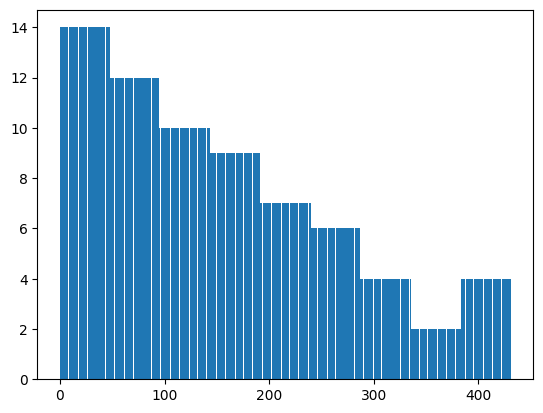

In [ ]:
Nbr_graph = make_graph(struct, 4.0)
np.shape(Nbr_graph)
plt.hist(Nbr_graph[:,0], len(A))
plt.show()

In [ ]:
len(Nbr_graph)

144

In [ ]:
state = generate_state(n_sites=len(A),density=7/15)
inds = []
for ind, sites in enumerate(Nbr_graph):
  if np.sum(state[sites]) == 1:
    inds.append(ind)
p = inds[np.random.randint(0,len(inds))]
i, j = Nbr_graph[p]
new_state = switch(state,i,j)
dE_main = Energy(new_state,A) - Energy(state,A)
dE_old = switch_energy(state,i,j,A)
dE_1 = switch_energy1(state,i,j,A)
dE_h = switch_energy_fields(state,i,j,A)
dE_main, dE_old, dE_1, dE_h

(0.12408494586043162,
 0.12408494586040675,
 0.1240849458604063,
 0.12408494586041252)

In [ ]:
acc, mc_energies = MHMC(n_steps=10000000, density=7/15, T=900, graph=Nbr_graph, A_mat=A)
autocorr_gw2010(mc_energies[1000000:], c=5.0)

2254.794427285412

In [ ]:
Init_state = generate_state(n_sites=len(A),density=7/15)
acc_rate, mc_energies = MHMC_alt(n_steps=40000000, init_state=Init_state, density=7/15, T=500, graph=Nbr_graph, A_mat=A)
tau = int(autocorr_gw2010(mc_energies[4000000:], c=5.0))
tau, len(mc_energies[400000:][::tau]), acc_rate

(13649, 2902, 0.2216746)

In [ ]:
temps, C_vals = heat_capacities(temps=np.arange(500,1501,100),n_steps=40000000)
# plt.plot(temps,C_vals,'x')

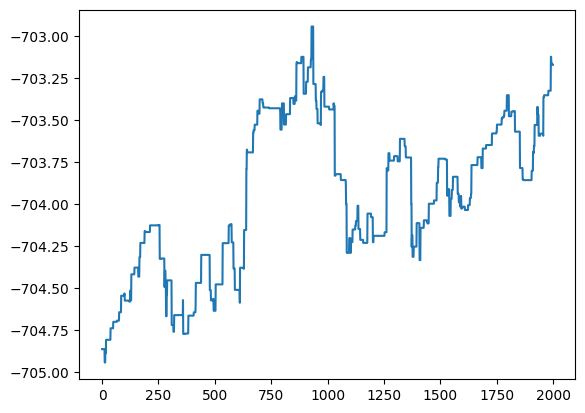

In [ ]:
plt.plot(range(0,len(mc_energies[10000:12000])), mc_energies[10000:12000])
plt.show()

In [ ]:
tau

4754

In [ ]:
jk = np.array([1,3,2,4,3,5])
np.nonzero(jk!=3)[0]

array([0, 2, 3, 5])

no. of states = 96, tau = 4237
no. of states = 103, tau = 30579
no. of states = 110, tau = 28609
no. of states = 120, tau = 21353
no. of states = 131, tau = 19540
no. of states = 143, tau = 17691
no. of states = 157, tau = 15017
no. of states = 172, tau = 14195
no. of states = 187, tau = 14129
no. of states = 202, tau = 13825
no. of states = 216, tau = 14373
no. of states = 229, tau = 16609
no. of states = 238, tau = 22426
no. of states = 248, tau = 20914
no. of states = 259, tau = 19703
no. of states = 267, tau = 27776
no. of states = 276, tau = 24678
no. of states = 284, tau = 27284
no. of states = 292, tau = 28047
no. of states = 300, tau = 26707
no. of states = 308, tau = 27065
no. of states = 316, tau = 25722
no. of states = 324, tau = 25789
no. of states = 333, tau = 24841
no. of states = 342, tau = 24637
no. of states = 351, tau = 23736
no. of states = 359, tau = 28165
no. of states = 367, tau = 26478
no. of states = 375, tau = 27923
no. of states = 383, tau = 26616
no. of state

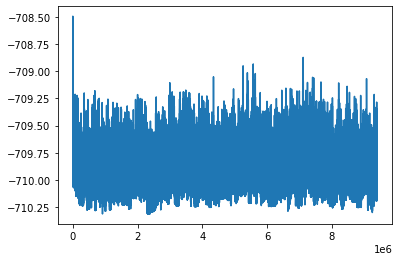

In [ ]:
states, energies = MHMC(n_states=520, density=7/15, T=250, graph=Nbr_graph, A_mat=A)
plt.plot(range(0,len(energies)), energies)
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Datasets/MC Data/LLZO_250_7-15', states)
# states = np.load('/content/drive/MyDrive/Datasets/MC Data/LLZO1016.npy', allow_pickle=True)

In [ ]:
while True:
  pass

KeyboardInterrupt: ignored

In [ ]:
plt.plot(range(0,len(energies))[100000:], energies[100000:])
plt.show()

**PCA**

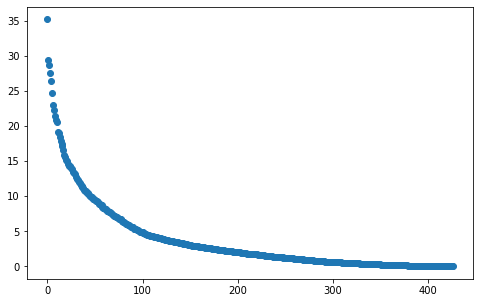

In [ ]:
figsize(8,5)
X = StandardScaler(with_std=False).fit_transform(eig_decomp_mat)
pca = PCA()
principalComponents = pca.fit_transform(X)
plt.plot(pca.singular_values_, 'o')
plt.show()

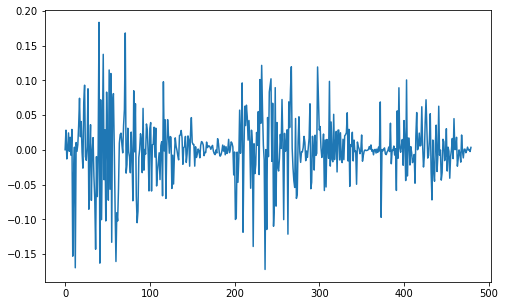

In [ ]:
plt.plot(np.arange(len(pca.components_[0])),pca.components_[0])
plt.show()

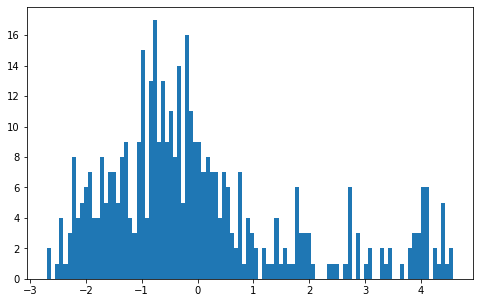

In [ ]:
plt.hist(principalComponents[:,0],bins=100)
plt.show()

In [ ]:
np.all(generate_state(len(A),7/15)==0)

In [ ]:
a = np.array([[1, 2], [3, 4],[5,6]])
b = np.array([[5, 6],[7,8]])
c = np.zeros((0,0))
np.concatenate((a,b,c), axis=0)

In [ ]:
df = pd.DataFrame(columns=cols)
df.loc[len(df)] = [1,1,0,1]
display(df)

In [ ]:
cols = list(np.arange(4))
for i in range(len(cols)):
  cols[i] = str(cols[i])
cols

In [ ]:
df.loc[len(df)] = np.array([0,0,0,1])
display(df)

In [ ]:
df.loc[::2]

In [ ]:
np.concatenate((np.zeros((5,3)),np.ones((2,3))),axis=0)

In [ ]:
eigvals, eigvecs = np.linalg.eigh(A)

In [ ]:
eig_decomp_mat = np.matmul(states[100:], eigvecs)

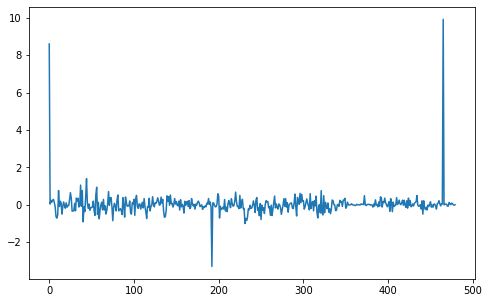

In [ ]:
plt.plot(np.arange(len(eig_decomp_mat[2])), eig_decomp_mat[300])
plt.show()

In [ ]:
Li_Cif = ('/content/drive/MyDrive/CIF Files/llzo cubic.cif')
llzo_cif = CifFile.from_file(Li_Cif)

In [ ]:
!pip install pybtex
from pymatgen.io.cif import CifParser, CifFile, CifBlock

     |████████████████████████████████| 561 kB 5.2 MB/s 


In [ ]:
llzo_cif.orig_string

"\n#(C) 2018 by FIZ Karlsruhe - Leibniz Institute for Information Infrastructure.  All rights reserved.\ndata_183607-ICSD\n_database_code_ICSD 183607\n_audit_creation_date 2012-08-01\n_audit_update_record 2013-08-01\n_chemical_name_systematic 'Heptalithium trilanthanum dizirconium dodecaoxide'\n_chemical_formula_structural 'Li7 La3 Zr2 O12'\n_chemical_formula_sum 'La3 Li7 O12 Zr2'\n_chemical_name_structure_type Li7La3Zr2O12\n_exptl_crystal_density_diffrn 5.07\n_cell_measurement_temperature 293.\n_publ_section_title\n'Lithium distribution in aluminum-free cubic Li7 La3 Zr2 O12'\nloop_\n_citation_id\n_citation_journal_full\n_citation_year\n_citation_journal_volume\n_citation_page_first\n_citation_page_last\n_citation_journal_id_ASTM\nprimary 'Chemistry of Materials' 2011 23 3587 3589 CMATEX\nloop_\n_publ_author_name\n'Xie, Hui'\n'Alonso, J.A.'\n'Li, Yu Tao'\n'Fernandez Diaz, M.T.'\n'Goodenough, J.B.'\n_cell_length_a 13.0035\n_cell_length_b 13.0035\n_cell_length_c 13.0035\n_cell_angle_alp

In [ ]:
#CifParser.get_bibtex_string(llzo_cif.data)
cif_parse = CifParser(Li_Cif)

In [ ]:
CifParser.get_bibtex_string(llzo_cif.orig_string)

AttributeError: ignored

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime
